<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

!pip install Pillow==4.1.1

tcmalloc: large alloc 1073750016 bytes == 0x578cc000 @  0x7f020a8d12a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 5.7MB 6.2MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [3]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually.

from google.colab import drive
drive.mount('/content/drive')

!tar -xvzf "/content/drive/My Drive/handout.tar.gz"
!wget https://raw.githubusercontent.com/fakefeik/Practical_DL/ekb2018/homework04/beheaded_inception3.py

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data/
data/captions_tokenized.json
data/image_codes.npy
--2018-11-22 16:15:02--  https://raw.githubusercontent.com/fakefeik/Practical_DL/ekb2018/homework04/beheaded_inception3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1811 (1.8K) [text/plain]
Saving to: ‘beheaded_inception3.py.1’

beheaded_inception3 100%[===================>]   1.77K  --.-KB/s    in 0s      

2018-11-22 16:15:02 (176 MB/s) - ‘beheaded_inception3.py.1’ saved [1811/1811]



### Data preprocessing

In [4]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 216 ms, sys: 729 ms, total: 945 ms
Wall time: 945 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [5]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for caption in captions:
    for sentence in caption:
        for word in sentence:
            word_counts[word] += 1

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [10]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
use_cuda, torch.version.cuda, torch.__version__

(True, '9.2.148', '0.4.1')

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048, num_layers=1):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        self.num_layers = num_layers
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix) 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(batch_first=True, input_size=emb_size, hidden_size=lstm_units, num_layers=num_layers)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None].repeat(self.num_layers, 1, 1), initial_hid[None].repeat(self.num_layers, 1, 1)))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [0]:
network = CaptionNet(n_tokens)

In [155]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048))
dummy_capt_ix = Variable(torch.LongTensor(as_matrix(captions[0])))

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    mask = (captions_ix_next != pad_ix).float()
    loss = torch.mean((mask*F.nll_loss(F.log_softmax(logits_for_next, dim=-1).transpose(1, 2), captions_ix_next)).sum()/mask.sum())
    
    return loss

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [0]:
def maybe_cuda(o):
    return o.cuda() if use_cuda else o

In [0]:
network = maybe_cuda(network)
opt = torch.optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return Variable(maybe_cuda(torch.FloatTensor(batch_images))), Variable(maybe_cuda(torch.LongTensor(batch_captions_ix)))
    

In [162]:
generate_batch(img_codes,captions,3)

(tensor([[0.5303, 0.0110, 0.2652,  ..., 0.0493, 0.1504, 0.8039],
         [0.3985, 0.0495, 0.3636,  ..., 0.1096, 0.1673, 0.3828],
         [0.0998, 0.0357, 0.1203,  ..., 0.9644, 1.1794, 0.1174]],
        device='cuda:0'),
 tensor([[   1,   24,  438,  243,   58,   24,  932,   14,  438,    6,  214,   15,
           889,  998,   12,    2],
         [   1,   24,  386,   15, 1844,   94,   50,   45,  209,   12,    2,    3,
             3,    3,    3,    3],
         [   1,   24,  272,   15,   47,  392,  357,  210,  194,   15,   24,  988,
           975,    2,    3,    3]], device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

def train(name, model, opt, n_epoch=100, batch_size=50, n_batches_per_epoch=50, n_validation_batches=5, save_best=True, early_stop_after=10):
    val_losses = []
    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss=0
        model.train(True)
        for _ in range(n_batches_per_epoch):
            loss_t = compute_loss(model, *generate_batch(train_img_codes, train_captions, batch_size))

            # clear old gradients; do a backward pass to get new gradients; then train with opt
            opt.zero_grad()
            loss_t.backward()
            opt.step()

            train_loss += loss_t.data.cpu().numpy()

        train_loss /= n_batches_per_epoch

        val_loss=0
        model.train(False)
        for _ in range(n_validation_batches):
            loss_t = compute_loss(model, *generate_batch(val_img_codes, val_captions, batch_size))
            val_loss += loss_t.data.cpu().numpy()
        val_loss /= n_validation_batches

        print(f'\rEpoch  #{epoch + 1}/{n_epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, took {time.time() - start_time:.2f} seconds', end='')


        val_losses.append(val_loss)

        local_max = np.min(val_losses)

        if save_best and val_losses[-1] == local_max:
            torch.save(model.state_dict(), name)

        if len(val_losses) > early_stop_after and local_max not in val_losses[-early_stop_after:]:
            print(f'\nEarly stopped after epoch #{epoch + 1}', end='')
            break
    print(f'\nBest validation loss: {np.min(val_losses):.4f}' + (f', best model saved to "{name}"' if save_best else ''))

    plt.title(name)
    plt.xlabel('n_epoch')
    plt.ylabel('loss')
    plt.plot(list(range(1, len(val_losses) + 1)), val_losses)
    plt.show()

Добавил сохранение лучшей модели

Epoch  #100/100, train loss: 1.5647, val loss: 1.4858, took 1.43 seconds
Best validation loss: 1.3157, best model saved to "baseline"


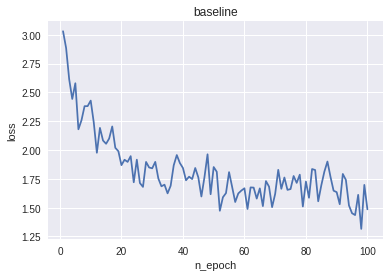

In [164]:
train('baseline', network, opt, early_stop_after=100)

Попробовал использовать больше слоев в LSTM, качество не улучшилось

Epoch  #100/100, train loss: 1.5691, val loss: 1.5795, took 1.84 seconds
Best validation loss: 1.4447, best model saved to "baseline2"


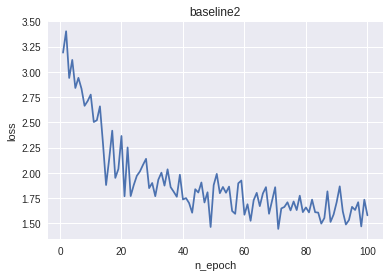

In [165]:
network = CaptionNet(n_tokens, num_layers=3)
network = maybe_cuda(network)
opt = torch.optim.Adam(network.parameters())
train('baseline2', network, opt, early_stop_after=100)

Попробовал увеличить размер эмбединга и количество весов в LSTM

Epoch  #100/100, train loss: 1.4763, val loss: 1.6875, took 2.19 seconds
Best validation loss: 1.2597, best model saved to "baseline3"


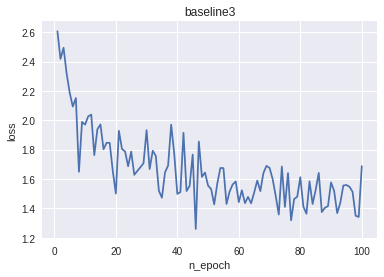

In [166]:
network = CaptionNet(n_tokens, emb_size=256, lstm_units=512)
network = maybe_cuda(network)
opt = torch.optim.Adam(network.parameters())
train('baseline3', network, opt, early_stop_after=100)

Попробовал увеличить размер батча и количество батчей в эпохе

Epoch  #100/100, train loss: 1.2752, val loss: 1.3739, took 4.86 seconds
Best validation loss: 1.1447, best model saved to "baseline4"


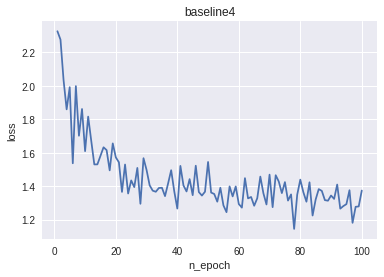

In [167]:
network = CaptionNet(n_tokens)
network = maybe_cuda(network)
opt = torch.optim.Adam(network.parameters())
train('baseline4', network, opt, batch_size=100, n_batches_per_epoch=100, n_validation_batches=10, early_stop_after=100)

Epoch  #100/100, train loss: 1.1461, val loss: 1.2107, took 8.42 seconds
Best validation loss: 1.0723, best model saved to "baseline5"


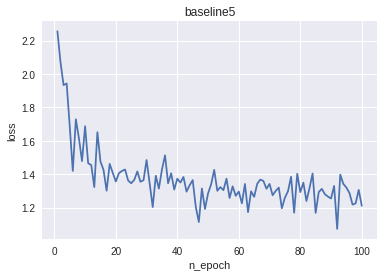

In [168]:
network = CaptionNet(n_tokens, emb_size=256, lstm_units=512)
network = maybe_cuda(network)
opt = torch.optim.Adam(network.parameters())
train('baseline5', network, opt, batch_size=100, n_batches_per_epoch=100, n_validation_batches=10, early_stop_after=100)

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [0]:
network.load_state_dict(torch.load('baseline5'))

In [0]:
from beheaded_inception3 import beheaded_inception_v3
inception = maybe_cuda(beheaded_inception_v3().train(False))

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(maybe_cuda(torch.FloatTensor(image.transpose([2, 0, 1]))))
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = Variable(maybe_cuda(torch.LongTensor(prefix_ix)))
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.cpu().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [172]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
from skimage.transform import resize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = resize(plt.imread('data/img.jpg'), (299, 299), mode='constant')

--2018-11-22 18:34:51--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.120.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.120.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105.40K  --.-KB/s    in 0.02s   

2018-11-22 18:34:51 (6.63 MB/s) - ‘data/img.jpg’ saved [107928/107928]



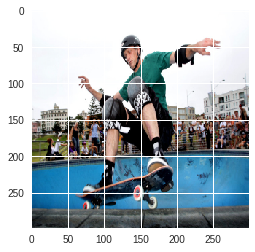

In [173]:
plt.imshow(img)

In [174]:
for i in range(10):
    print(' '.join(generate_caption(img1, t=5.)[1:-1]))

a man jumping in the air with a skateboard .
a man jumping in the air with a skateboard .
a man riding a skateboard up the side of a ramp .
a man on a skateboard doing a trick on a ramp .
a man is doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a person on a skateboard does a trick on a ramp .
a man riding a skateboard up the side of a ramp .
a man on a skateboard jumping up in the air .
a man riding a skateboard up the side of a ramp .


In [175]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg

def print_captions(image_path):
    img = resize(plt.imread(image_path), (299, 299), mode='constant')
    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2018-11-22 18:34:57--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.02s   

2018-11-22 18:34:57 (6.27 MB/s) - ‘data/img.jpg’ saved [106870/106870]



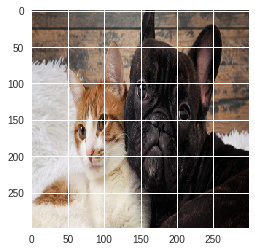

a cat is sitting in a black suitcase .
a cat is sitting on a chair with a black cat .
a cat is sitting in a black suitcase .
a cat is sitting in a chair with a stuffed animal .
a cat sitting on a chair with a red ribbon .
a cat is laying down on a couch .
a cat is sitting on a couch with a stuffed animal .
a cat is sitting next to a teddy bear .
a cat is sitting on a chair with a stuffed animal .
a cat is sitting on a couch with a teddy bear .


In [176]:
print_captions('data/img.jpg')

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [177]:
#apply your network on image sample you found
#
#
!wget https://pbs.twimg.com/media/Dsifg27XgAE2MYi.jpg -O data/img1.jpg
!wget https://pbs.twimg.com/media/Dsiv89LWwAIuMbf.jpg -O data/img2.jpg
!wget https://pbs.twimg.com/media/DsXLzCLX4AI7lxJ.jpg -O data/img3.jpg
!wget https://pbs.twimg.com/media/DshfAJOWsAAAKIF.jpg -O data/img4.jpg
!wget https://pbs.twimg.com/media/DsYPwNzXgAAl1LP.jpg -O data/img5.jpg
!wget https://pbs.twimg.com/media/Dslg6YdWoAEYi3A.jpg -O data/img6.jpg
!wget https://pbs.twimg.com/media/DsIZx8lWoAAUt1V.jpg -O data/img7.jpg
!wget https://pbs.twimg.com/media/C_pXqqjUIAAS2ex.jpg -O data/img8.jpg
!wget https://i.kym-cdn.com/entries/icons/mobile/000/027/100/_103330503_musk3.jpg -O data/img9.jpg
!wget https://cdn-images-1.medium.com/max/1600/1*MzqQm_K3sdO8RFibufJJBA.jpeg -O data/img10.jpg

--2018-11-22 18:35:01--  https://pbs.twimg.com/media/Dsifg27XgAE2MYi.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.233.50, 2606:2800:134:fa2:1627:1fe:edb:1665
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.233.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53645 (52K) [image/jpeg]
Saving to: ‘data/img1.jpg’

data/img1.jpg       100%[===================>]  52.39K  --.-KB/s    in 0.005s  

2018-11-22 18:35:01 (10.8 MB/s) - ‘data/img1.jpg’ saved [53645/53645]

--2018-11-22 18:35:04--  https://pbs.twimg.com/media/Dsiv89LWwAIuMbf.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.233.50, 2606:2800:134:fa2:1627:1fe:edb:1665
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.233.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185117 (181K) [image/jpeg]
Saving to: ‘data/img2.jpg’

data/img2.jpg       100%[===================>] 180.78K  --.-KB/s    in 0.01s   

2018-11-22 18:35:04 (17.0 MB/s) - ‘data/img2.jpg’ saved [

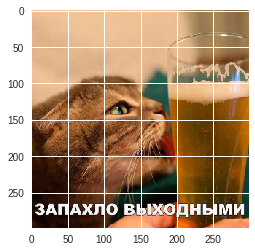

a cat is sitting on a table next to a glass of wine .
a cat is sitting on a table with a bottle of wine .
a cat is sitting in a car seat .
a cat is sitting on a table next to a bottle of wine .
a cat is sitting on a table with a bottle of wine .
a cat is sitting on a table with a bottle of wine .
a cat is sitting in a car seat .
a cat that is sitting on a table .
a cat that is sitting on a table .
a cat is sitting on a table with a bottle of liquid .


In [189]:
print_captions('data/img1.jpg')

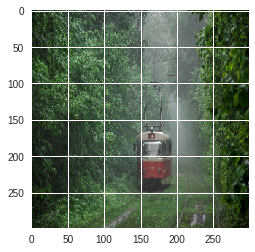

a truck is parked on a street with trees in the background .
a red train traveling down tracks next to a forest .
a red truck driving down a road near a forest .
a train traveling down tracks next to a forest .
a truck driving down a road next to a forest .
a red train traveling down tracks next to a forest .
a train is traveling down the tracks in a rural area .
a train traveling down tracks next to a forest .
a train traveling down tracks next to a forest .
a red truck driving down a street next to trees .


In [190]:
print_captions('data/img2.jpg')

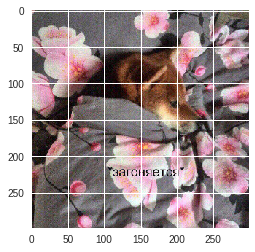

a dog is sitting in a car seat .
a dog is laying on a bed with a stuffed animal .
a dog is laying on a bed with a stuffed animal .
a dog is laying on a bed with a stuffed animal .
a dog is laying on a bed with a stuffed animal .
a dog is laying on a bed with a stuffed animal .
a dog is laying on a bed with a stuffed animal .
a dog is laying on a bed with a stuffed toy .
a dog laying on a bed with a stuffed animal .
a dog is laying on a couch with a stuffed toy .


In [191]:
print_captions('data/img3.jpg')

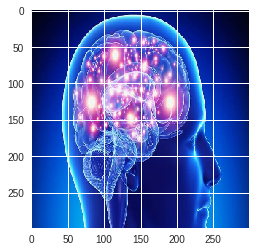

a close up of a person holding a pair of scissors
a close up of a person holding a pair of scissors
a close up of a person holding a pair of scissors
a close up of a person holding a pair of scissors
a close up of a person holding a carrot
a close up of a person holding a camera
a group of three different colored ties sitting on a table .
a close up of a person holding a camera
a close up of a person holding a pair of scissors
a close up of a person holding a pair of scissors


In [192]:
print_captions('data/img4.jpg')

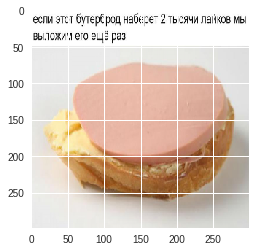

a cake with strawberries on top of it
a chocolate cake with strawberries on a plate .
a cake with strawberries on it and a fork .
a cake with a knife and fork on it
a donut with a bite taken out of it on a white plate .
a cake with a knife and a fork .
a plate of food with a fork and a knife .
a cake with a knife and a fork .
a cake with a knife and a fork .
a cake on a plate with a fork .


In [193]:
print_captions('data/img5.jpg')

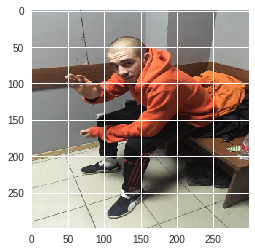

a man is playing a game on the wii .
a man is standing on a toilet in a room .
a man is playing a game on a skateboard .
a man is standing in a bathroom with a toilet .
a man is standing on a skateboard in a room .
a man in a blue shirt and black shorts playing a game
a man is playing a game on a skateboard .
a man in a white shirt and black shorts playing a game of wii .
a man is playing a game on the nintendo wii .
a man is playing a game of wii .


In [194]:
print_captions('data/img6.jpg')

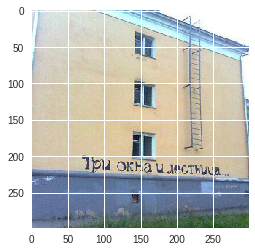

a large clock tower is shown in front of a building .
a large clock tower on a cloudy day .
a large clock tower is shown in the middle of the afternoon .
a large clock tower is shown in the middle of the day .
a large clock tower on a cloudy day .
a large clock tower sitting below a building .
a clock tower in the middle of a city .
a large clock tower sitting on top of a building .
a large white clock tower sitting on top of a building .
a large clock tower is shown in front of a building .


In [195]:
print_captions('data/img7.jpg')

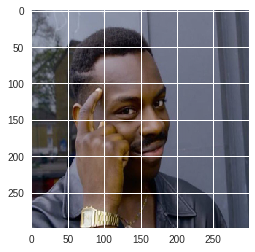

a man with glasses is talking on a cell phone .
a man is eating a hot dog in a crowded street .
a man is taking a selfie in a mirror .
a man with glasses is talking on a cell phone .
a man with glasses is eating a doughnut .
a man with glasses is holding a glass of wine .
a man with glasses is talking on a cell phone .
a man with glasses is eating a hot dog .
a man with glasses is talking on a cell phone .
a man with glasses is talking on a cell phone .


In [196]:
print_captions('data/img8.jpg')

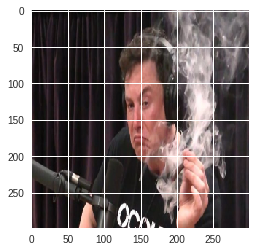

a man in a suit and tie is standing in front of a mirror .
a man in a tie is talking to a woman .
a man in a blue shirt and tie is drinking a glass of wine .
a man in a suit and tie is smiling .
a man in a tie and a tie and a black shirt
a man with a tie and a beard is smiling .
a man in a red shirt is talking on a cell phone .
a man with glasses is talking on a cell phone .
a man in a suit and tie is smiling
a man in a suit and tie is smiling .


In [197]:
print_captions('data/img9.jpg')

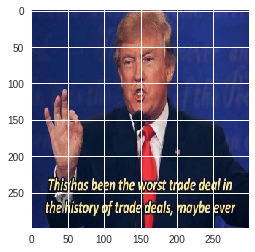

a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a microphone .
a man in a suit and tie standing in front of a crowd .
a man in a suit and tie standing in front of a house .
a man in a suit and tie standing in front of a microphone .
a man in a suit and tie posing for a picture .
a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a microphone .
a man in a suit with a camera and a tie .


In [198]:
print_captions('data/img10.jpg')

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563